# Bayesian analysis of the effects of Daylight Savings Time (DST) adjustment on the incidence rate of Acute Myocardial Infarction (AMI)

## Notes

In this notebook I called the risk ratio (RR) the incidence rate ratio (IRR).

## Code

In [1]:
%load_ext jupyter_spaces

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import arviz as az

import utils
import plots

# filter out the useless category warnings 
logging.getLogger('matplotlib.category').setLevel(logging.WARNING)

In [4]:
plt.rcParams.update({
    'axes.grid': True,
    'grid.color': '0.6',
    'grid.alpha': 0.5,
    'xtick.minor.visible': True
})

In [5]:
logger = logging.getLogger('BayesianScience')

logger.setLevel(logging.DEBUG)

In [6]:
all_data = defaultdict(lambda: {'trend': None, 'obs': None})

In [7]:
param_space = np.linspace(-0.2, 0.8, 1000, endpoint=False)
param_grid_size = (param_space[-1] - param_space[0]) / (len(param_space) - 1)

In [8]:
PARAM_EXPON_MEAN = 0.2
PARAM_NORMAL_SD = 0.01

def get_prior(param_space):
    
    m0 = stats.norm.pdf(param_space,
                        scale=PARAM_NORMAL_SD)

    m1 = stats.expon.pdf(param_space,
                         scale=PARAM_EXPON_MEAN)

    prior = 0.5 * m0 + 0.5 * m1

    logger.debug("Total probability mass in prior: {:.3f}\n"
                 "(The rest of the exponential component falls out of the parameter space.)"
                 .format(prior.sum() * utils.linspace_step(param_space)))

    return prior

prior = get_prior(param_space)

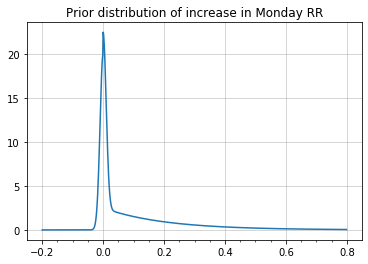

In [9]:
plt.title("Prior distribution of increase in Monday RR")
plt.plot(param_space, prior)
plt.grid(True)
plt.show()

## Janszky and Ljung (2008)

Janszky and Ljung. 2008. _Shifts to and from Daylight Saving Time and Incidence of Myocardial Infarction_. The New England Journal of Medicine.  BMC Public Health. 359; 18. [link](https://www.nejm.org/doi/full/10.1056/NEJMc0807104)

**Data**:
 - data: from the Swedish registry of acute myocardial infarction
 - years: 1987–2006
 - observations: the incidence of AMI during each of the first 7 days after the spring or autumn transition
 - trend: the mean of the incidences on the corresponding weekdays 2 weeks before and 2 weeks after the day of interest


**Quotes**:

> The effects of transitions were consistently more pronounced for people under 65 years of age than for those 65 years of age or older.

The authors properly controlled for the Easter holiday.
> Analyses of the data for the spring shift are based on the 15 years between 1987 and
2006 in which Easter Sunday was not the transition day.
> [...]
> For years in which Easter
Sunday was celebrated 2 weeks after the Sunday of the spring shift, we defined the control period for the Sunday of
the shift as the Sunday 3 weeks before and the Sunday 3 weeks after (thus skipping Easter Sunday).

**Overanalysis**:

The following observations do not have any plausible explanation, and are probably just noise. Question: did later studies confirm these findings?

1.
> When we did
not exclude Easter if it coincided with the exposure or control days, we observed an even higher effect size associated
with the spring transition.

2.
> For the autumn shift, in contrast to the analyses of all acute myocardial infarctions, analyses restricted to fatal cases showed a smaller decrease in the incidence of acute myocardial infarction on Monday, and the risk of fatal acute myocardial infarction increased during the first week after the shift. 

3.
> The effect of the spring transition to daylight saving time on the incidence of acute myocardial infarction was somewhat more pronounced in women than in men, and the autumn effect was more pronounced in men than in women.


**Additional information**:

The authors were employed by institutions in Stockholm, Sweden, meaning there's no evidence for them picking the only dataset that supported their hypothesis.

In [10]:
data_figure_1a_raw = """\
1439/1374
1735/1636
1644/1494
1555/1471
1522/1484
1467/1422
1414/1370"""

num_years = 15

ami_obs, ami_trend = utils.parse_data(data_figure_1a_raw,
                                      utils.DAYS_OF_WEEK)

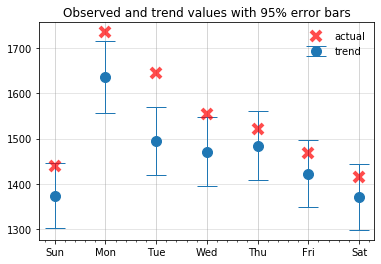

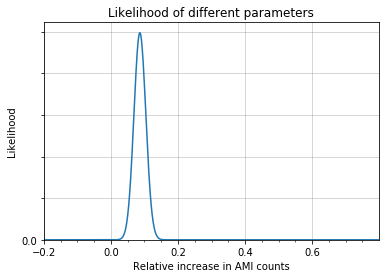

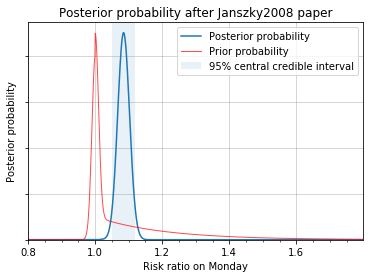

In [11]:
paper_id = 'Janszky2008'

all_data[paper_id]['trend'] = ami_trend
all_data[paper_id]['obs'] = ami_obs

plots.plot_results(param_space, prior, all_data, paper_id)

## Janszky et al. (2012)

Janszky, Ahnve, Ljung, Mukamal, Gautam, Wallentin, Stenestrand. 2012. _Daylight saving time shifts and incidence of acute myocardial infarction – Swedish Register of Information and Knowledge About Swedish Heart Intensive Care Admissions (RIKS-HIA)_. Sleep Medicine 13 (2012) 237–242. [link](https://www.sciencedirect.com/science/article/abs/pii/S1389945711003832)

**Data**:
 - those AMI patients who were admitted to CCUs at participating hospitals
 - from 1995 to 2007

This study didn't publish per-day AMI counts, only the total during the whole posttransitional week. Judging by the number of patients, this included about 50% of the Swedish population. As the time period matches exactly that of Janszky and Ljung (2008), these two results are highly correlated, and should be treated as the analysis of a subpopulation. This study doesn't add new information to the previous work with regards to the variables we consider, and as such, it is excluded from our meta-analysis.

As the authors put it:
> In a largely overlapping population, we confirmed our previous
finding that there is a short term increase in risk for AMI after
the transition into DST.

## Čulić (2013)

Viktor Čulić. 2013. _Daylight saving time transitions and acute myocardial infarction_. Chronobiology International. 2013; 30(5): 662–668. [link](https://www.tandfonline.com/doi/abs/10.3109/07420528.2013.775144)

**Data**:

- patients hospitalized because of AMI
- from 1990 to 1996
- 40 patients on workdays following DST change
- at University Hospital Centre Split in Split, Croatia

It is unclear whether the trend prediction is made from the 2 weeks before and after the posttransitional week, or from all 50 nontransitional weeks:

> The incidence ratios of AMI for the first week after the
two DST shifts (posttransitional weeks) and each day of
that week were estimated by dividing the incidence
during those periods with the average incidences during
corresponding days and weeks throughout the year: 2
wks before and 2 wks after the posttransitional week,
and the 50 nontransitional weeks of the year altogether.

It is unclear why exactly the data from 1990 to 1996 was analyzed, if the study was conducted in 2013. This is suggestive of selection bias.

**Overanalysis**:

23 additional variables were analyzed (man, woman, employed, retired, use of β-blocker, etc.); some were bound to have low p-values:

> The independent predictors for AMI during
this period in spring were male sex (p = 0.03) and nonengagement in physical activity (p = 0.02) and there was a trend
for the lower risk of incident among those taking calcium antagonists (p = 0.07). In autumn, the predictors were
female sex (p = 0.04), current employment (p = 0.006), not taking b-blocker (p = 0.03), and nonengagement in
physical activity (p = 0.02).

In [12]:
data_figure_1_raw = """\
5/6.2
14/7.2
6/6.9
9/7
6/6.2
5/6.5
8/5.9"""

num_years = 7

ami_obs, ami_trend = utils.parse_data(data_figure_1_raw,
                                      utils.DAYS_OF_WEEK)

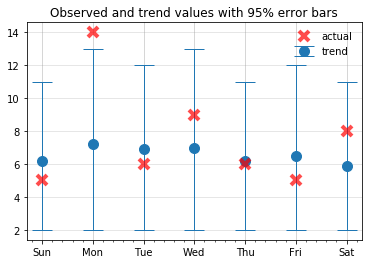

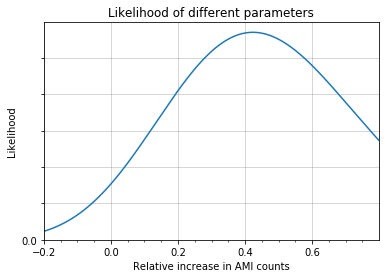

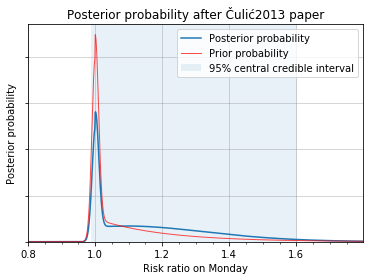

In [13]:
paper_id = 'Čulić2013'

all_data[paper_id]['trend'] = ami_trend
all_data[paper_id]['obs'] = ami_obs

plots.plot_results(param_space, prior, all_data, paper_id)

## Jiddou et al. (2013)

Monica R. Jiddou, MD, Mark Pica, BS, Judy Boura, MS, Lihua Qu, MS, and Barry A. Franklin, PhD. 2013. _Incidence of Myocardial Infarction With Shifts to and From Daylight Savings Time_. The American Journal of Cardiology. Volume 111, Issue 5, Pages 631–635. [link](http://dx.doi.org/10.1016/j.amjcard.2012.11.010)

**Data**:
- a retrospective electronic chart review
- all patients presenting to the emergency centers at Beaumont Hospitals in Royal Oak and Troy, Michigan, with the primary diagnosis of AMI
- age: patients who were aged >18 years, resulting in 70±15 years
- exclusion conditions: minor, pregnant
- from October 2006 to April 2012 (7 years)
- trend: patients admitted with comparable diagnoses on the corresponding weekdays 2 weeks before and 2 weeks after the shifts to and from DST
- additional variables: demographic data, medical history, tobacco use, prescribed medications, whether the patient underwent cardiac catheterization; diagnosis of hypertension, hyperlipidemia, and coronary artery disease.

**Methodological issues**:

1.
> 2 AMIs occurred on Easter Sunday and were considered potential confounders and excluded.

It is correct to note the incidences on Easter Sunday, but even more important would be the incidences on Easter _Monday_. But even then, is only correct to exclude the patients entirely if the relevant control incidences are also reduced.

In [14]:
data_figure_1_raw = """\
23/13.44
28/29.5
28/20.0
26/23.0
23/17.5
24/25.5
18/16.5"""

num_years = 7

trend_multiplier = 2

spring_obs, spring_trend = utils.parse_data(data_figure_1_raw,
                                      utils.DAYS_OF_WEEK)

In [15]:
data_figure_3_raw = """\
11/18.77
34/24.0
25/21.5
19/27.5
20/22.5
18/24.0
30/20.0"""

fall_obs, fall_trend = utils.parse_data(data_figure_3_raw,
                                        utils.DAYS_OF_WEEK)

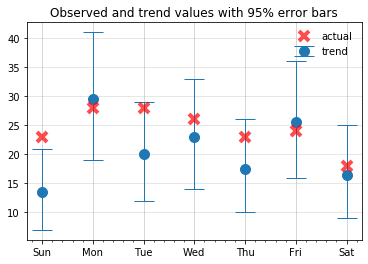

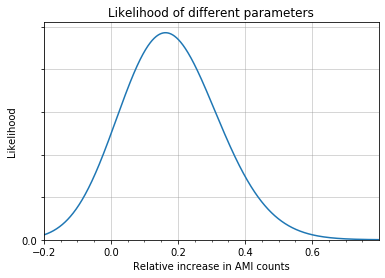

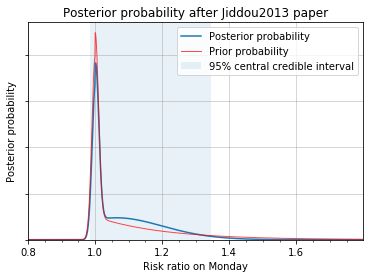

In [16]:
paper_id = 'Jiddou2013'

all_data[paper_id]['trend'] = spring_trend
all_data[paper_id]['obs'] = spring_obs

plots.plot_results(param_space, prior, all_data, paper_id)

## Sandhu et al. (2014)

Timeline: 1 January 2010 – 15 September 2013 (3 fall and 4 spring DST changes)

> Procedural data for hospital admissions where PCI was performed in the setting of AMI between 1 January 2010 and 15 September 2013 were included in this analysis.

> In this study, 42 060 hospital admissions for AMI requiring PCI occurred during the study period. Figure 1A provides a plot of the daily PCIs performed for AMI over 1354 days included in the study period. The median daily AMI total was 31, ranging from a minimum of 14 to a maximum of 53 admissions.

**Results**

> There was no difference in the total weekly number of PCIs performed for AMI for either the fall or spring time changes in the time period analysed. After adjustment for trend and seasonal effects, the Monday following spring time changes was associated with a 24% increase in daily AMI counts (p=0.011), and the Tuesday following fall changes was conversely associated with a 21% reduction (p=0.044). No other weekdays in the weeks following DST changes demonstrated significant associations.

As I was unable to obtain the data at [Blue Cross Blue Shield of Michigan](https://bmc2.org), I estimated the number of AMI cases from the chart in Figure 3.

Screenshot taken of figure and analyzed with [WebPlotDigitizer](https://apps.automeris.io/wpd/).

Measurement error: 1 pixel, which is $150\text{AMI}\, /\, (517-131)\text{px} ≈ 0.4$ AMIs

Figure 3 of Sandhu et al. (2014):
![Figure 3 - AMI counts after 4 years of spring DST adjustment](figs/Sandhu2014-Figure3-Spring.png)

In [17]:
ami_obs_str = """\
0.00, 108.00
1.00, 170.00
2.00, 125.33
3.00, 122.00
4.00, 116.67
5.00, 116.67
6.00, 114.00"""

ami_obs = {day: round(count)
           for day, count in zip(utils.DAYS_OF_WEEK, utils.parse_second_column(ami_obs_str))}

In [18]:
ami_obs

{'Sun': 108,
 'Mon': 170,
 'Tue': 125,
 'Wed': 122,
 'Thu': 117,
 'Fri': 117,
 'Sat': 114}

In [19]:
ami_trend_str = """\
0.00, 111.33
1.00, 138.33
2.00, 127.67
3.00, 125.33
4.00, 120.33
5.00, 120.00
6.00, 110.33\
"""

ami_trend = utils.parse_second_column(ami_trend_str)
ami_trend = {day: count
           for day, count in zip(utils.DAYS_OF_WEEK, utils.parse_second_column(ami_trend_str))}

In [20]:
ami_trend

{'Sun': 111.33,
 'Mon': 138.33,
 'Tue': 127.67,
 'Wed': 125.33,
 'Thu': 120.33,
 'Fri': 120.0,
 'Sat': 110.33}

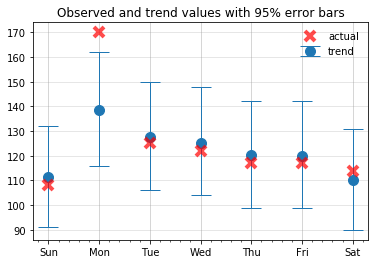

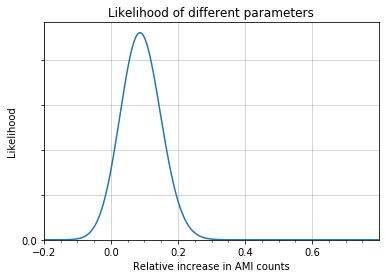

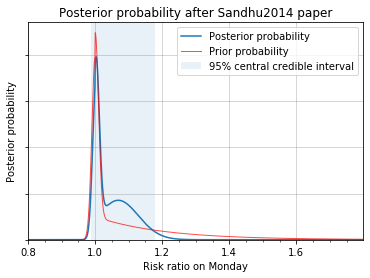

In [21]:
# The poisson error bars are not very meaningful,
#   apart from "Whoa, look at how big of an outlier!"

paper_id = 'Sandhu2014'

all_data[paper_id]['trend'] = ami_trend
all_data[paper_id]['obs'] = ami_obs

plots.plot_results(param_space, prior, all_data, paper_id)

# Kirchberger et al. (2015)

Kirchberger et al. 2015. _Are daylight saving time transitions associated with changes in myocardial infarction incidence? Results from the German MONICA/KORA Myocardial Infarction Registry_. BMC Public Health. 2015; 15: 778. [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4535383/)

**Data**:
- AMI count: 25,499 cases of AMI
- data source: MONICA/KORA Myocardial Infarction Registry ([link](https://www.helmholtz-muenchen.de/herzschlag-info/); public data should be published yearly according to [this website](http://www.gbe-bund.de/gbe10/abrechnung.prc_abr_test_logon?p_uid=gast&p_aid=0&p_knoten=FID&p_sprache=E&p_suchstring=7014), but I did not find a link to download the dataset) 
- time period: 1 January 1985 and 31 October 2010 (26 spring and 25 fall DST changes – 2010 fall adjustment was on 31 October)
- ages: 25–74
- includes: coronary death and AMI
- location: city of Augsburg (Germany) and the two adjacent counties (about 600,000 inhabitants)
- additional variables: information on re-infarction, various medication prior to AMI, current occupation, history of hypertension, hyperlipidemia, diabetes, smoking, and obesity.
- confounders accounted for: global time trend, temperature, relative humidity, barometric pressure, and indicators for month of the year, weekday and holiday

> The final model included the following covariates: time trend and previous two day mean relative humidity as regression splines with four and two degrees of freedom, respectively, previous two day mean temperature as a linear term and day of the week as categorical variable.

> The optimized spring model [of the data from March and April, excluding the week in question] included time trend and same day mean relative humidity as regression splines with six and three degrees of freedom.

Six d.o.f. for 2 months is probably overfitting the data, even though it was the sum of 26 years. However, it shouldn’t make a predictible effect, and overall it likely had a negligible effect.

> The incidence rate ratio was assessed as observed over expected events per day and the mean per weekday and corresponding 95% confidence intervals were calculated.

However, it is not stated how the confidence intervals were calculated. It most likely wasn't a Bayesian _credible interval_ because they didn't specify the priors; so then the exact statistical test  confidence intervals would require

In [22]:
total_ami = 25_499
total_days = 9435
ami_per_day = total_ami / total_days
print("On average: {:.2f} AMI/day (stdev for the 25-year-average: {:.2f})".format(
            ami_per_day,
            stats.poisson(total_ami).std() / total_days,
            stats.poisson(ami_per_day).std()))

On average: 2.70 AMI/day (stdev for the 25-year-average: 0.02)


Assuming the researchers analyzed the data in an honest manner (i.e. not picking model parameters for lower prediction and more significant observed increase), and that the model didn't predict large deviations from the 2.7 AMI/day average, we can calculate Bayes factors using only the mean incidence ratios.

In [23]:
data_table_3_raw = """\
	Spring predicition model 	Autumn predicition model
Weekday	IRR [95 % CI]	IRR [95 % CI]
Sunday	0.937 [0.732; 1.141]	0.881 [0.667; 1.095]
Monday	1.207 [0.915; 1.500]	0.850 [0.572; 1.129]
Tuesday	1.185 [0.852; 1.519]	1.135 [0.861; 1.409]
Wednesday	1.075 [0.854; 1.297]	1.077 [0.832; 1.321]
Thursday	1.098 [0.809; 1.388]	1.133 [0.883; 1.383]
Friday	1.203 [0.950; 1.457]	1.244 [1.035; 1.453]
Saturday	0.850 [0.657; 1.043]	0.892 [0.657; 1.127]\
"""

mean_irr_spring = {}
mean_irr_autumn = {}

for line in data_table_3_raw.split('\n')[2:]:
    day_raw, spring_raw, autumn_raw = line.split('\t')
    
    day = day_raw[:3]
    f = lambda s: float(s.split(' ')[0])
    spring, autumn = map(f, (spring_raw, autumn_raw))
    mean_irr_spring[day] = spring
    mean_irr_autumn[day] = autumn

In [24]:
mean_irr_spring

{'Sun': 0.937,
 'Mon': 1.207,
 'Tue': 1.185,
 'Wed': 1.075,
 'Thu': 1.098,
 'Fri': 1.203,
 'Sat': 0.85}

In [25]:
mean_irr_autumn

{'Sun': 0.881,
 'Mon': 0.85,
 'Tue': 1.135,
 'Wed': 1.077,
 'Thu': 1.133,
 'Fri': 1.244,
 'Sat': 0.892}

Over 26 springs this adds up to:

In [26]:
num_years = 26

ami_trend = {day: ami_per_day * num_years for day in utils.DAYS_OF_WEEK}
ami_obs = {day: round(ami_trend[day] * mean_irr_spring[day]) for day in utils.DAYS_OF_WEEK}

In [27]:
num_years = 25

autumn_trend = {day: ami_per_day * num_years for day in utils.DAYS_OF_WEEK}
autumn_obs = {day: round(autumn_trend[day] * mean_irr_autumn[day]) for day in utils.DAYS_OF_WEEK}

In [28]:
autumn_trend, autumn_obs

({'Sun': 67.56491785903552,
  'Mon': 67.56491785903552,
  'Tue': 67.56491785903552,
  'Wed': 67.56491785903552,
  'Thu': 67.56491785903552,
  'Fri': 67.56491785903552,
  'Sat': 67.56491785903552},
 {'Sun': 60, 'Mon': 57, 'Tue': 77, 'Wed': 73, 'Thu': 77, 'Fri': 84, 'Sat': 60})

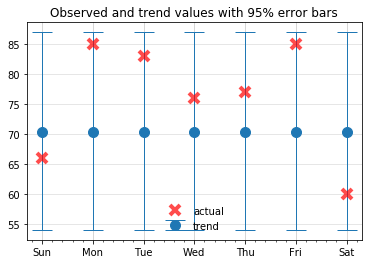

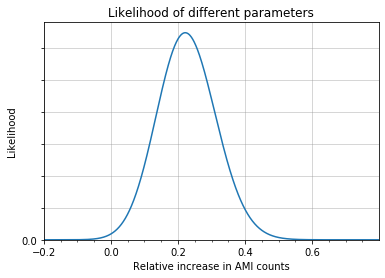

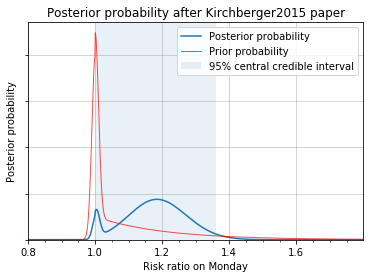

In [29]:
paper_id = 'Kirchberger2015'

all_data[paper_id]['trend'] = ami_trend
all_data[paper_id]['obs'] = ami_obs

plots.plot_results(param_space, prior, all_data, paper_id)

## Sipilä et al. (2016)

Jussi O.T. Sipilä, Päivi Rautava & Ville Kytö. 2016. _Association of daylight saving time transitions with incidence and in-hospital mortality of myocardial infarction in Finland_. Annals of Medicine, 48:1-2, 10-16. [link](http://dx.doi.org/10.3109/07853890.2015.1119302)

**Data**:
 - years: 2001–2009 except 2002, 2005. 7 years.
 - Exclusion criterion: age < 18.
 - Age: mean age 71.2, SD 12.6 years
 - 2 weeks prior and 3 weeks after DST transition
 - all 22 Finnish hospitals with coronary catheterization laboratory that treat emergency cardiac patients
 - database: Finnish Care Register for Health Care (CRHC), a nationwide, obligatory and automatically collected hospital discharge database.

 - Study group: posttransitional week
 - Control group: 2 weeks before/after posttransitional week
 - Easter in study group: 2002, 2005. “Years with DST spring transition on Easter Sunday were excluded from the analysis (2002 and 2005) to increase international comparability and avoid confounding”
 - Easter in control group: “When Easter Sunday was celebrated within 2 weeks after DST transition, post-DST control weeks after Easter were selected.”
 
 - Spring study+control group size: 1269+5029 = 6298
 
 - Additional variables: TODO Appendix 1

 - Standardized incidence of MI admissions in participating hospitals during spring study period was 259/100,000 person-years.


**Noteworthy quote**:

> Incidence of MI admissions was similar to control
weeks for Sunday–Tuesday after DST transition
(Figure 1). However, on fourth day after transition
(Wednesday), there was a significant increase in MI
incidence compared to control weeks (IR 1.16; CI 1.01–
1.34).

Is there anything special about the _Wednesday_ that follows a DST transition? One should not be surprised if a value falls outside of a 95% confidence/credible interval – after all, it happens _at least_ 5% of the time even in the absence of any "interesting" effect.

**Overanalysis**:

> Patients admitted
during the week after DST transition were less likely to
have diagnosed diabetes or ventricular arrhythmias
compared to patients admitted during control weeks,
but had diagnosed renal failure more often.




What does this mean:
> Population-based incidence
of MI admissions to participating hospitals during
spring and autumn periods were calculated using
corresponding population data of mainland Finland
obtained from Statistics Finland and standardized to
European standard population 2013 by using the direct
method.

In [30]:
data_figure_1_raw = """\
201/835
229/1077
253/975
254/1036
262/908
242/909
179/793"""

# the trend counts are the sum of 4 weeks 
trend_multiplier = 4

spring_obs, spring_trend = utils.parse_data(data_figure_1_raw,
                                            utils.DAYS_OF_WEEK)

for day in spring_trend:
    spring_trend[day] /= trend_multiplier

In [31]:
data_figure_2_raw = """\
160/639
214/790
180/772
198/681
199/806
172/713
153/628
"""

fall_obs, fall_trend = utils.parse_data(data_figure_2_raw,
                                        utils.DAYS_OF_WEEK)

for day in fall_trend:
    fall_trend[day] /= trend_multiplier

Below I perform a sanity check for data input.
The difference is most likely due to the fact that patients on Easter were included in one figure but not in the other.

In [32]:
EASTER_INV_ADJUSTMENT = 9/7
SUNDAY_INV_ADJUSTMENT = 24/23
s = '{:.1f} ≈ {:.1f}'
print('Adjusted sum from Figure 1 ≈ adjusted sum from Results section')
print(s.format(sum(n if d != 'Sun' else n * SUNDAY_INV_ADJUSTMENT
                   for d,n in spring_obs.items ()),
               1269 * EASTER_INV_ADJUSTMENT))
print(s.format(sum(spring_trend.values()) * trend_multiplier,
               5029 * EASTER_INV_ADJUSTMENT))

Adjusted sum from Figure 1 ≈ adjusted sum from Results section
1628.7 ≈ 1631.6
6533.0 ≈ 6465.9


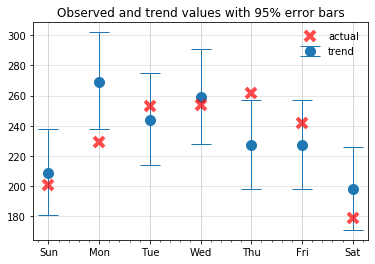

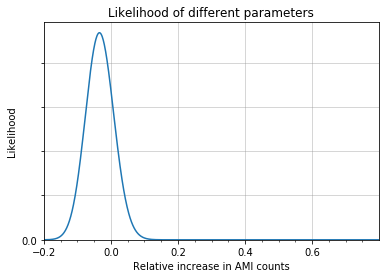

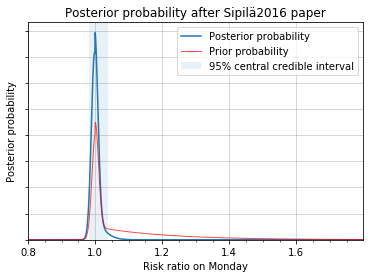

In [33]:
paper_id = 'Sipilä2016'

all_data[paper_id]['trend'] = spring_trend
all_data[paper_id]['obs'] = spring_obs

plots.plot_results(param_space, prior, all_data, paper_id)

## Save the data

In [34]:
with open('all_data.pickle', 'wb') as f:
    pickle.dump(dict(all_data), f)

# Test

For a short study, i.e. if the trend and observed AMI counts are low, we want to see a very slight change in the prior (i.e. a very flat likelihood); for a large study, we want to see a bigger change.

Two factors should play into this. First, if the trend predicts low counts, then we are likely to observe relatively big fluctuations. Second, if the study was short, our _estimate_ of the trend itself has greater variance. This second factor is not yet modeled in our work, but in small studies like that of Čulić (2013), this too plays a role.


- Observation higher than trend, small sample size
- Observation equals trend, large sample size
- Observation lower than trend, large sample size
- Observation higher than trend, large sample size

INFO:BayesianScience:X, 0.9840, 1.3860
INFO:BayesianScience:X, 0.9830, 1.0270
INFO:BayesianScience:X, 0.9570, 0.9930
INFO:BayesianScience:X, 1.0920, 1.1800


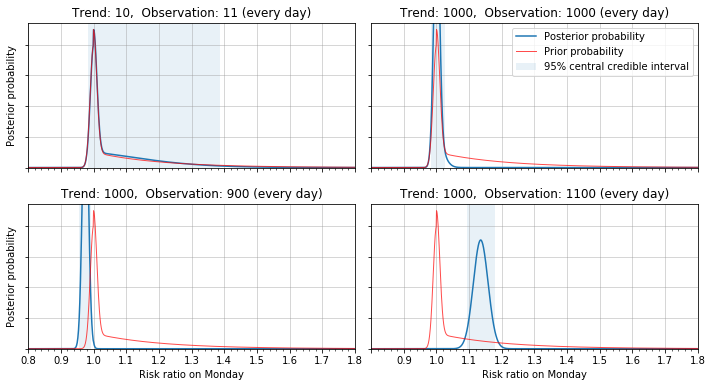

In [275]:
# Yes, I'm aware that third of the likelihood is off the charts for the top-left figure.
# Extending the parameter space for this analysis results in the same posterior,
#   because the prior is close to zero.
# > param_space = np.linspace(0.3, 2.0, 1000)
# > prior = get_prior(param_space, EXPECTED_MONDAY_INCREASE)

fig, axes = plt.subplots(2,2, sharey=True)
fig.set_size_inches((12,6))


for i, (t,o) in enumerate([(10,11), (1000,1000), (1000,900), (1000, 1100)]):
    ax = axes.flat[i]
    plt.sca(ax)
    
    ami_trend = {d: t for d in utils.WEEKDAYS}
    ami_obs = {d: o for d in utils.WEEKDAYS}
    
    log_likelihood = utils.calc_log_likelihood(param_space, ami_trend, ami_obs)
    posterior = utils.calc_posterior(
        param_space,
        prior,
        log_likelihood)
    
    plots.plot_posterior(param_space, prior, posterior, paper_title="X", legend=False)

    plt.title(f"Trend: {t},  Observation: {o} (every day)")

for col in [0,1]:
    axes[0,col].set_xlabel("")
    axes[0,col].set_xticklabels("")
    
for row in [0,1]:
    axes[row,1].set_ylabel("")
    for col in [0,1]:
        axes[row,col].set_xticks(np.arange(param_space[0] + 1, param_space[-1] + 1.05, 0.1))

# axes[1,1].set_xticklabels(['–0.2', '–0.1', '0.0', '0.1'])
# axes[1,0].set_xticklabels([str(x) for x in np.arange(-0.2, 0.8)])
axes[1,1].set_xticklabels(['', *['%.1f' % x for x in np.arange(0.9, 1.85, 0.1)]])
axes[0,1].legend()

plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.savefig('figs/test-posteriors.svg')

plt.show()

## Aggregating results from all studies

In [37]:
log_likelihoods = {title: utils.calc_log_likelihood(param_space, paper_data['trend'], paper_data['obs'])
                   for title, paper_data in all_data.items()}

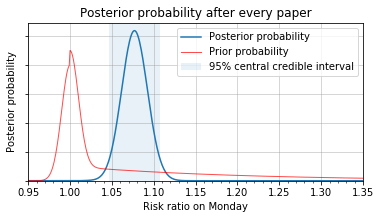

In [44]:
combined_posterior = utils.calc_posterior(param_space, prior, log_likelihoods.values())
ci_lb, ci_ub = plots.plot_posterior(param_space, prior, combined_posterior, paper_title = "every")
plt.gcf().set_size_inches((6,3))
plt.xlim(0.95, 1.35)
plt.subplots_adjust(bottom=0.15)
plt.xlabel('Risk ratio on Monday')
plt.savefig('figs/combined_posterior.svg')
plt.show()

In [45]:
print(f"95% central credible interval of IRR: [{ci_lb*100:.1f}%, {ci_ub*100:.1f}%]")
print('Posterior mean of IRR: %.1f%%' % (np.dot(param_space, combined_posterior) * param_grid_size * 100)) 

95% central credible interval of IRR: [104.7%, 110.8%]
Posterior mean of IRR: 7.7%


## Forest plot

INFO:BayesianScience:Janszky2008, 1.0500, 1.1200
INFO:BayesianScience:Čulić2013, 0.9870, 1.6010
INFO:BayesianScience:Jiddou2013, 0.9850, 1.3440
INFO:BayesianScience:Sandhu2014, 0.9870, 1.1780
INFO:BayesianScience:Kirchberger2015, 0.9990, 1.3590


Janszky2008, mean: 1.0848072330731022
Čulić2013, mean: 1.1639595836552947
Jiddou2013, mean: 1.0821641416371581
Sandhu2014, mean: 1.0485780751666562
Kirchberger2015, mean: 1.1780030881037433


INFO:BayesianScience:Sipilä2016, 0.9800, 1.0370


Sipilä2016, mean: 1.0012428163290303


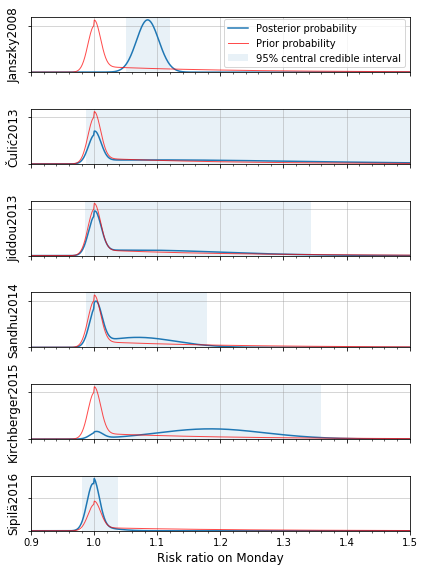

In [446]:
num_axes = len(all_data)
fig, axes = plt.subplots(num_axes, 1)

fig.set_size_inches((6, 8))

for i, (ax, title) in enumerate(zip(axes, all_data.keys())):
    plt.sca(ax)
    ax.set_title(title)

    posterior = utils.calc_posterior(param_space,
                                     prior,
                                     log_likelihoods[title])
    print(f'{title}, mean: {1 + np.dot(param_space, posterior) * utils.linspace_step(param_space)}')
    plots.plot_posterior(param_space, prior, posterior, paper_title=title, legend=False)
    
    ax.set_title("")
    ax.set_ylabel(title)
    ax.set_xlim(0.9, 1.5)
    ax.set_xticks(np.arange(0.9, 1.55, 0.1))
    ax.set_yticklabels([])

for ax in axes[:-1]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])
    
axes[0].legend()
fig.tight_layout()

# plt.savefig('figs/forest_plot.svg')
plt.show()

## Visualizing the observations and the posterior predictive distribution

Here we visualize the posterior predictive distribution (for each day of each paper), together with the actual observation

$$P(\tilde o | \mathcal D) =
\int P(\tilde o | \theta, \mathcal D) \,d\theta = 
\int P(\tilde o | \theta) p(\theta | \mathcal D) \,d\theta$$

Janszky2008
{'Mon': (1667, 1859), 'Tue': (1501, 1673), 'Wed': (1458, 1621), 'Thu': (1452, 1609), 'Fri': (1369, 1519)}
[1735, 1644, 1555, 1522, 1467]

Čulić2013
{'Mon': (3, 14), 'Tue': (3, 13), 'Wed': (3, 13), 'Thu': (2, 12), 'Fri': (2, 12)}
[14, 6, 9, 6, 5]

Jiddou2013
{'Mon': (21.0, 43.0), 'Tue': (13.0, 31.0), 'Wed': (15.0, 34.0), 'Thu': (10.0, 27.0), 'Fri': (16.0, 36.0)}
[28, 28, 26, 23, 24]

Sandhu2014
{'Mon': (125, 174), 'Tue': (113, 159), 'Wed': (109, 154), 'Thu': (103, 146), 'Fri': (101, 144)}
[170, 125, 122, 117, 117]

Kirchberger2015
{'Mon': (59, 93), 'Tue': (58, 92), 'Wed': (57, 91), 'Thu': (56, 90), 'Fri': (55, 88)}
[85, 83, 76, 77, 85]

Sipilä2016
{'Mon': (256.0, 325.0), 'Tue': (227.0, 291.0), 'Wed': (239.0, 304.0), 'Thu': (204.0, 265.0), 'Fri': (201.0, 261.0)}
[229, 253, 254, 262, 242]
Sipilä2016/Mon falls out of the credible interval [256. 325.]



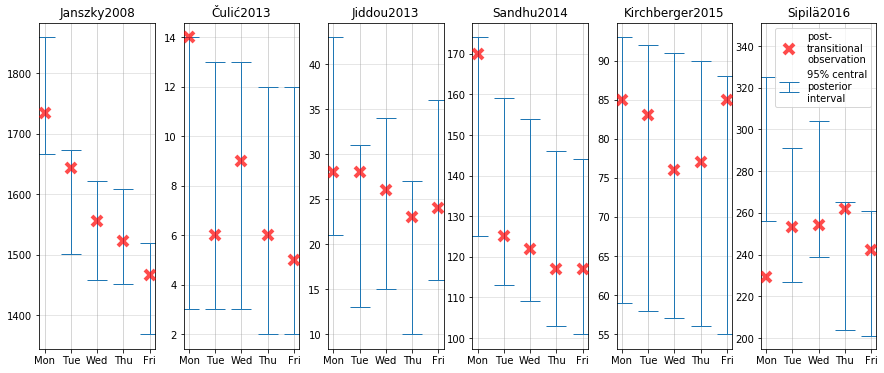

In [362]:
alpha_percent = 5

num_axes = len(all_data)
fig, axes = plt.subplots(1, num_axes)

fig.set_size_inches((15,6))

for i, (ax, (title, paper_data)) in enumerate(zip(axes, all_data.items())):
    plt.sca(ax)
    ax.set_title(title)
    y_range = np.arange(2*max(*paper_data['trend'].values(), *paper_data['obs'].values()))
    
    posterior_predictive = defaultdict(lambda: np.zeros(y_range.shape, dtype=np.float64))
    yerr = {}
    
    for d, factor in zip(utils.WEEKDAYS, np.linspace(1, 0, len(utils.WEEKDAYS), endpoint=False)):
        day_param_space = (1 + param_space * factor) * paper_data['trend'][d]
        for y_idx, y_pred in enumerate(y_range):
            posterior_predictive[d][y_idx] = np.dot(stats.poisson.pmf(y_pred, day_param_space),
                                                    combined_posterior)
            
        posterior_predictive[d] *= utils.linspace_step(param_space)
        
        yerr[d] = utils.central_credible_interval_discrete(y_range,
                                                           posterior_predictive[d],
                                                           alpha=alpha_percent/100)

    data_weekdays = [paper_data['obs'][d] for d in utils.WEEKDAYS]

    yerr_all = np.vstack([*yerr.values()]).T
    yerr_mean = np.mean(yerr_all, axis=0)
    print(title)
    print(yerr)
    print(data_weekdays)
    for d,obs,yerr in zip(utils.WEEKDAYS, data_weekdays, yerr_all.T):
        if not yerr[0] <= obs <= yerr[1]:
            print(f'{title}/{d} falls out of the credible interval {yerr}')
    print()
    plt.errorbar(utils.WEEKDAYS, yerr_mean, yerr=np.abs(yerr_all - yerr_mean), fmt=' ',
                 elinewidth=1, capsize=10, ms=0,
                 label=f'{100-alpha_percent}% central\nposterior\ninterval')
    plt.plot(utils.WEEKDAYS, data_weekdays, 'x', c='red', ms=10, mew=4, alpha=0.7, zorder=10,
             label='post-\ntransitional\nobservation')
    plt.grid(True, axis='y', alpha=0.3)
    
    ax.minorticks_off()
    

axes[-1].set_ylim(top=axes[-1].get_ylim()[1]+20)    
axes[-1].legend(loc='upper right')

plt.subplots_adjust(wspace=0.25)

plt.savefig(f'figs/posterior_predictive_{100-alpha_percent}.svg')
plt.show()

If the observations don’t fit the intervals, then either the prior, the model, or the data is incorrect.

Observations that fall out of the 90% central posterior interval:
 - Čulić2013/Mon
 - Sipilä2016/Mon
 - Sipilä2016/Thu
 
...out of the 95%:
 - Sipilä2016/Mon

## Create LaTeX table

In [9]:
total_obs = 0

for title, data in sorted(all_data.items(), key= lambda item: item[0]):
    print('%s' % title, end='')
    trend, obs = (data[x].values() for x in ['trend', 'obs'])
    total_obs += sum(obs)
    
#     print(r' & \myX{%d}{%d}' % (sum(trend), sum(obs)), end='')
    
    for t, o in zip(trend, obs):
        print(r' & \myX{%d}{%d}' % (t, o), end='')
    
    print(r' \\')
    
print()
print('Total obs: %d' % total_obs)

Janszky2008 & \myX{1374}{1439} & \myX{1636}{1735} & \myX{1494}{1644} & \myX{1471}{1555} & \myX{1484}{1522} & \myX{1422}{1467} & \myX{1370}{1414} \\
Jiddou2013 & \myX{13}{23} & \myX{29}{28} & \myX{20}{28} & \myX{23}{26} & \myX{17}{23} & \myX{25}{24} & \myX{16}{18} \\
Kirchberger2015 & \myX{70}{66} & \myX{70}{85} & \myX{70}{83} & \myX{70}{76} & \myX{70}{77} & \myX{70}{85} & \myX{70}{60} \\
Sandhu2014 & \myX{111}{108} & \myX{138}{170} & \myX{127}{125} & \myX{125}{122} & \myX{120}{117} & \myX{120}{117} & \myX{110}{114} \\
Sipilä2016 & \myX{208}{201} & \myX{269}{229} & \myX{243}{253} & \myX{259}{254} & \myX{227}{262} & \myX{227}{242} & \myX{198}{179} \\
Čulić2013 & \myX{6}{5} & \myX{7}{14} & \myX{6}{6} & \myX{7}{9} & \myX{6}{6} & \myX{6}{5} & \myX{5}{8} \\

Total obs: 14024


## Create Markdown table

In [185]:
titles_nice = {
    'Janszky2008': '(Janszky and Ljung, 2008)',
    'Jiddou2013': '(Jiddou et al., 2013)',
    'Kirchberger2015': '(Kirchberger et al., 2015)',
    'Sandhu2014': '(Sandhu et al., 2014)',
    'Sipilä2016': '(Sipilä et al., 2016)',
    'Čulić2013': '(Čulić, 2013)'
}

In [17]:
total_obs = 0

for title, data in sorted(all_data.items(), key= lambda item: item[0]):
    print('| %s' % titles_nice[title], end='')
    trend, obs = (data[x].values() for x in ['trend', 'obs'])
    total_obs += sum(obs)

    for t in trend:
        print(r' | (%d)' % t, end='')
    print(r' |')

    print('|    ', end='')
    for o in obs:
        print(r' | %d' % o, end='')
    
    print(r' |')
    
print()
print('Total obs: %d' % total_obs)

| (Janszky and Ljung, 2008) | (1374) | (1636) | (1494) | (1471) | (1484) | (1422) | (1370) |
|     | 1439 | 1735 | 1644 | 1555 | 1522 | 1467 | 1414 |
| (Jiddou et al., 2013) | (13) | (29) | (20) | (23) | (17) | (25) | (16) |
|     | 23 | 28 | 28 | 26 | 23 | 24 | 18 |
| (Kirchberger et al., 2015) | (70) | (70) | (70) | (70) | (70) | (70) | (70) |
|     | 66 | 85 | 83 | 76 | 77 | 85 | 60 |
| (Sandhu et al., 2014) | (111) | (138) | (127) | (125) | (120) | (120) | (110) |
|     | 108 | 170 | 125 | 122 | 117 | 117 | 114 |
| (Sipilä et al., 2016) | (208) | (269) | (243) | (259) | (227) | (227) | (198) |
|     | 201 | 229 | 253 | 254 | 262 | 242 | 179 |
| (Čulić, 2013) | (6) | (7) | (6) | (7) | (6) | (6) | (5) |
|     | 5 | 14 | 6 | 9 | 6 | 5 | 8 |

Total obs: 14024


### Create CSV file

In [277]:
import csv

In [289]:
def print_csv(filename, data_dict):
    with open(filename, 'w') as csvfile:
        csvwriter = csv.writer(csvfile)

        header_row = ['Study']
        for day in utils.DAYS_OF_WEEK:
            header_row.append(f'{day} (trend)')
        for day in utils.DAYS_OF_WEEK:
            header_row.append(f'{day} (observed)')
        csvwriter.writerow(header_row)

        for title, data in sorted(data_dict.items(), key= lambda item: item[0]):
            row = [title]
            for day in utils.DAYS_OF_WEEK:
                row.append(data['trend'][day])
            for day in utils.DAYS_OF_WEEK:
                row.append(data['obs'][day])
            csvwriter.writerow(row)

In [290]:
print_csv('spring.csv', all_data)

# Calculations with Stan

In [46]:
import pystan

In [47]:
with open('all_data.pickle', 'rb') as f:
    all_data = pickle.load(f)

In [70]:
from pathlib import Path

In [74]:
import os

In [82]:
def get_stan_model(model_name):
    model_path = os.path.join('stan', model_name + '.model')
    code_path = os.path.join('stan', model_name + '.stan')
    
    try:
        with open(model_path, 'rb') as f:
            sm = pickle.load(f)
    except FileNotFoundError:
        sm = pystan.StanModel(file=code_path)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)
            
    return sm

In [83]:
sm = get_stan_model('dst-linear')

In [198]:
arrayed_counts_x = lambda x: [[v[x][d] for d in utils.WEEKDAYS] for v in all_data.values()]
all_obs = arrayed_counts_x('obs')
all_trend = arrayed_counts_x('trend')

sm_data = {
    'STUDIES': len(all_obs),
    'DAYS': len(utils.WEEKDAYS),
    'NORMAL_SIGMA': 0.01,
    'EXPON_BETA': 1/0.2,
    'ami_obs': all_obs,
    'ami_trend': all_trend
}

In [85]:
all_obs

[[1735, 1644, 1555, 1522, 1467],
 [14, 6, 9, 6, 5],
 [28, 28, 26, 23, 24],
 [170, 125, 122, 117, 117],
 [85, 83, 76, 77, 85],
 [229, 253, 254, 262, 242]]

In [86]:
fit = sm.sampling(data=sm_data,
                  pars=['rr_day'],
                  iter=50000,
                  chains=4,
                  seed=0,
)

In [87]:
print(fit.stansummary())

Inference for Stan model: anon_model_11be072d0bb8e6ba72098b99fb2d2321.
4 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=100000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rr_day[1]   1.08  8.2e-5   0.02   1.05   1.07   1.08   1.09   1.11  35930    1.0
rr_day[2]   1.06  6.6e-5   0.01   1.04   1.05   1.06   1.07   1.09  35930    1.0
rr_day[3]   1.05  4.9e-5 9.3e-3   1.03   1.04   1.05   1.05   1.06  35930    1.0
rr_day[4]   1.03  3.3e-5 6.2e-3   1.02   1.03   1.03   1.04   1.04  35930    1.0
rr_day[5]   1.02  1.6e-5 3.1e-3   1.01   1.01   1.02   1.02   1.02  35930    1.0
lp__       6.0e4  3.4e-3   0.72  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4  45210    1.0

Samples were drawn using NUTS at Fri Nov  8 05:55:19 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


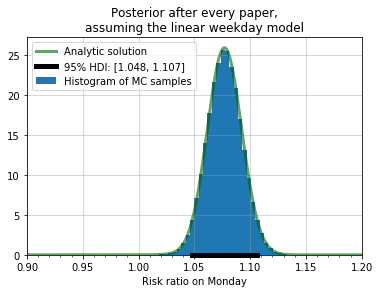

In [88]:
plt.xlim(0.9, 1.2)
plt.hist(fit['rr_day[1]'],
         bins=np.arange(*(param_space[[0,-1]] + 1), 1/256),
         density=True,
         label='Histogram of MC samples')
plt.plot(param_space+1, combined_posterior, 'darkgreen', alpha=0.6, lw=3, label='Analytic solution')
plots.plot_hdi_line(*az.hpd(fit['rr_day[1]']))
plt.legend()
plt.xlabel('Risk ratio on Monday')
plt.title('Posterior after every paper,\n'
          'assuming the linear weekday model')
plt.savefig('figs/posterior_mc.svg')
plt.show()

### With a uniform prior

In [91]:
sm = get_stan_model('dst-linear-uniform')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db2129361fba5fef976a134fa70e3605 NOW.


In [92]:
sm_data = {
    'STUDIES': len(all_obs),
    'DAYS': len(utils.WEEKDAYS),
    'ami_obs': all_obs,
    'ami_trend': all_trend
}

In [93]:
fit = sm.sampling(data=sm_data,
                  pars=['rr_day'],
                  iter=50000,
                  chains=4,
                  seed=0,
)

In [94]:
print(fit.stansummary())

Inference for Stan model: anon_model_db2129361fba5fef976a134fa70e3605.
4 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=100000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rr_day[1]   1.08  8.4e-5   0.02   1.05   1.07   1.08   1.09   1.11  34147    1.0
rr_day[2]   1.06  6.7e-5   0.01   1.04   1.05   1.06   1.07   1.09  34147    1.0
rr_day[3]   1.05  5.0e-5 9.3e-3   1.03   1.04   1.05   1.05   1.07  34147    1.0
rr_day[4]   1.03  3.3e-5 6.2e-3   1.02   1.03   1.03   1.04   1.04  34147    1.0
rr_day[5]   1.02  1.7e-5 3.1e-3   1.01   1.01   1.02   1.02   1.02  34147    1.0
lp__       6.0e4  3.2e-3   0.71  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4  48363    1.0

Samples were drawn using NUTS at Fri Nov  8 05:58:06 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


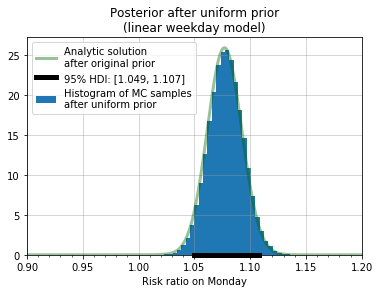

In [95]:
plt.xlim(0.9, 1.2)
plt.hist(fit['rr_day[1]'],
         bins=np.arange(*(param_space[[0,-1]] + 1), 1/256),
         density=True,
         label='Histogram of MC samples\n'
               'after uniform prior')
plt.plot(param_space+1, combined_posterior, 'darkgreen',
         alpha=0.4, lw=3,
         label='Analytic solution\n'
               'after original prior')
plots.plot_hdi_line(*az.hpd(fit['rr_day[1]']))
plt.legend()
plt.xlabel('Risk ratio on Monday')
plt.title('Posterior after uniform prior\n'
          '(linear weekday model)')
fig.tight_layout()
plt.savefig('figs/posterior_mc_uniform.svg')
plt.show()

### With exponential weekday model, uniform prior

In [199]:
sm = get_stan_model('dst-exp-uniform')

In [200]:
sm_data = {
    'STUDIES': len(all_obs),
    'DAYS': len(utils.WEEKDAYS),
    'ami_obs': all_obs,
    'ami_trend': all_trend
}

In [201]:
fit = sm.sampling(data=sm_data,
                  pars=['rr_day', 'rr_Mon_minus_1', 'rr_decay_per_day'],
                  iter=50000,
                  chains=4,
                  seed=0,
)

In [202]:
print(fit.stansummary())

Inference for Stan model: anon_model_2f961fceb62387b2025a5a62f95e4ed0.
4 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=100000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rr_day[1]          1.07  9.2e-5   0.02   1.04   1.06   1.07   1.08   1.11  32382    1.0
rr_day[2]          1.06  5.1e-5   0.01   1.04   1.05   1.06   1.07   1.08  51254    1.0
rr_day[3]          1.05  3.8e-5   0.01   1.03   1.04   1.05   1.06   1.07  86920    1.0
rr_day[4]          1.04  4.2e-5   0.01   1.02   1.03   1.04   1.05   1.06  82284    1.0
rr_day[5]          1.03  5.0e-5   0.01   1.01   1.03   1.03   1.04   1.06  67463    1.0
rr_Mon_minus_1     0.07  9.2e-5   0.02   0.04   0.06   0.07   0.08   0.11  32382    1.0
rr_decay_per_day   0.83  4.9e-4    0.1    0.6   0.77   0.84   0.91   0.99  42990    1.0
lp__              6.0e4  6.5e-3   1.11  6.0e4  6.0e4  6.0e4  6.0e4  6.0e4  29749    1.0

Samples were 

In [124]:
az.hpd(fit['rr_day[1]'])

array([1.04045842, 1.10199306])

In [143]:
np.mean(fit['rr_day[1]'])

1.070844244038522

In [125]:
az.hpd(fit['rr_decay_per_day'])

array([0.66057789, 0.99984873])

In [144]:
np.mean(fit['rr_decay_per_day'])

0.8308992617889372

In [126]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [257]:
x = fit['rr_day[1]']
y = fit['rr_decay_per_day']

In [258]:
x_min, x_max = 1.0, 1.15
y_min, y_max = 0.1, 1.05

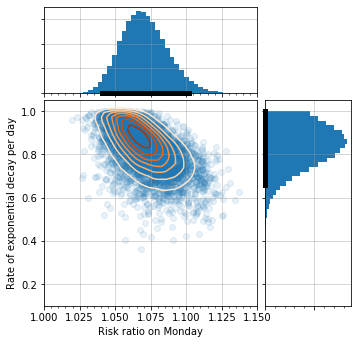

In [260]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

# the scatter plot:
N_scatter = 5000
axScatter.scatter(x[:N_scatter], y[:N_scatter], alpha=0.1)

k = stats.gaussian_kde((x, y))
xi, yi = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
axScatter.contour(xi, yi, zi.reshape(xi.shape), cmap='Oranges')

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

plots.plot_hdi_line(*az.hpd(x), axHistx)
plots.plot_hdi_line(*az.hpd(y), axHisty, horizontal=False)

# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

axHistx.hist(x, bins=40)
axHisty.hist(y, bins=40, orientation='horizontal')

axHistx.set_yticklabels([])
axHisty.set_xticklabels([])

axScatter.set_xlim(x_min, x_max)
axScatter.set_ylim(y_min, y_max)

axScatter.set_xlabel('Risk ratio on Monday')
axScatter.set_ylabel('Rate of exponential decay per day')

plt.savefig('figs/posterior_mc_exp.svg')
plt.show()

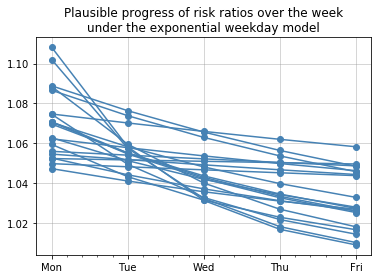

In [142]:
for i in range(20):
    plt.plot(utils.WEEKDAYS, fit['rr_day'][i], '-o', c='steelblue')
plt.title('Plausible progress of risk ratios over the week\n'
          'under the exponential weekday model')
plt.savefig('figs/risk_ratios_exp.svg')
plt.show()

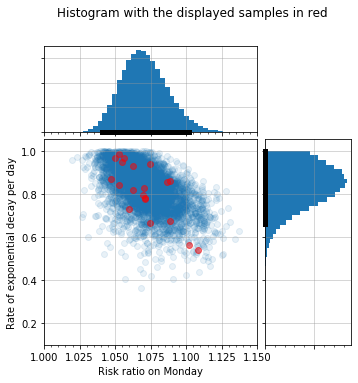

In [148]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

x = fit['rr_day[1]']
y = fit['rr_decay_per_day']

# the scatter plot:
N_scatter = 5000
axScatter.scatter(x[:N_scatter], y[:N_scatter], alpha=0.1)
N_scatter_red = 20
axScatter.scatter(x[:N_scatter_red], y[:N_scatter_red], c='r', alpha=0.5)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

plots.plot_hdi_line(*az.hpd(fit['rr_day[1]']), axHistx)
plots.plot_hdi_line(*az.hpd(fit['rr_decay_per_day']), axHisty, horizontal=False)

# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

axHistx.hist(x, bins=40)
axHisty.hist(y, bins=40, orientation='horizontal')

axHistx.set_yticklabels([])
axHisty.set_xticklabels([])

axScatter.set_xlim(1.0, 1.15)

axScatter.set_xlabel('Risk ratio on Monday')
axScatter.set_ylabel('Rate of exponential decay per day')

# plt.savefig('figs/posterior_mc_exp.svg')
plt.suptitle('Histogram with the displayed samples in red')
plt.show()

In [150]:
alphas = fit['rr_decay_per_day']
thetas = fit['rr_Mon_minus_1']

In [155]:
avg_rr = ((alphas ** 5 - 1) / (alphas - 1) * thetas) / 5 + 1

In [156]:
np.mean(avg_rr), az.hpd(avg_rr)

(1.0504888468642408, array([1.03069816, 1.07021307]))

## AMI counts after DST adjustment in autumn

In [183]:
autumn_data = {
    'Janszky2008': {
        'trend': {
            'Sun': 1780,
            'Mon': 2140,
            'Tue': 1991,
            'Wed': 1910,
            'Thu': 1941,
            'Fri': 1949,
            'Sat': 1781
        },
        'obs': {
            'Sun': 1777,
            'Mon': 2038,
            'Tue': 1958,
            'Wed': 1895,
            'Thu': 1916,
            'Fri': 1977,
            'Sat': 1732
        }
    },
    'Čulić2013': {
        'trend': {
            'Sun': 6.2,
            'Mon': 7.2,
            'Tue': 6.9,
            'Wed': 7,
            'Thu': 6.2,
            'Fri': 6.5,
            'Sat':5.9 
        },
        'obs': {
            'Sun': 7,
            'Mon': 9,
            'Tue': 12,
            'Wed': 6,
            'Thu': 12,
            'Fri': 5,
            'Sat': 4 
        }
    },
    'Jiddou2013': {
        'trend': {
            'Sun': 18.77,
            'Mon': 24.0,
            'Tue': 21.5,
            'Wed': 27.5,
            'Thu': 22.5,
            'Fri': 24.0,
            'Sat': 20.0
        },
        'obs': {
            'Sun': 11,
            'Mon': 34,
            'Tue': 25,
            'Wed': 19,
            'Thu': 20,
            'Fri': 18,
            'Sat': 30
        }
    },
    'Sandhu2014': {
        'trend': {
            'Sun': 86.8,
            'Mon': 107.5,
            'Tue': 99.3,
            'Wed': 97.6,
            'Thu': 93.7,
            'Fri': 93.3,
            'Sat': 85.8 
        },
        'obs': {
            'Sun': round(89.2),
            'Mon': round(102.0),
            'Tue': round(79.2),
            'Wed': round(92.9),
            'Thu': round(104.0),
            'Fri': round(86.1),
            'Sat': round(99.2)
        }
    },
    'Kirchberger2015': {
        # numbers copied from the Kirchberger section above
        'trend': {
            'Sun': 67.56491785903552,
            'Mon': 67.56491785903552,
            'Tue': 67.56491785903552,
            'Wed': 67.56491785903552,
            'Thu': 67.56491785903552,
            'Fri': 67.56491785903552,
            'Sat': 67.56491785903552
        },
        'obs': {
            'Sun': 60,
            'Mon': 57,
            'Tue': 77,
            'Wed': 73,
            'Thu': 77,
            'Fri': 84,
            'Sat': 60
        }
    },
    'Sipilä2016': {
        # the trend counts in the paper are the sum of 4 weeks
        'trend': {
            'Sun': 159.75,
            'Mon': 197.5,
            'Tue': 193.0,
            'Wed': 170.25,
            'Thu': 201.5,
            'Fri': 178.25,
            'Sat': 157.0
        },
        'obs': {
            'Sun': 160,
            'Mon': 214,
            'Tue': 180,
            'Wed': 198,
            'Thu': 199,
            'Fri': 172,
            'Sat': 153
        }
    }
}

In [186]:
total_obs = 0

for title, data in sorted(autumn_data.items(), key= lambda item: item[0]):
    print('| %s' % titles_nice[title], end='')
    trend, obs = (data[x].values() for x in ['trend', 'obs'])
    total_obs += sum(obs)

    for t in trend:
        print(r' | (%d)' % t, end='')
    print(r' |')

    print('|    ', end='')
    for o in obs:
        print(r' | %d' % o, end='')
    
    print(r' |')
    
print()
print('Total obs: %d' % total_obs)

| (Janszky and Ljung, 2008) | (1780) | (2140) | (1991) | (1910) | (1941) | (1949) | (1781) |
|     | 1777 | 2038 | 1958 | 1895 | 1916 | 1977 | 1732 |
| (Jiddou et al., 2013) | (18) | (24) | (21) | (27) | (22) | (24) | (20) |
|     | 11 | 34 | 25 | 19 | 20 | 18 | 30 |
| (Kirchberger et al., 2015) | (67) | (67) | (67) | (67) | (67) | (67) | (67) |
|     | 60 | 57 | 77 | 73 | 77 | 84 | 60 |
| (Sandhu et al., 2014) | (86) | (107) | (99) | (97) | (93) | (93) | (85) |
|     | 89 | 102 | 79 | 93 | 104 | 86 | 99 |
| (Sipilä et al., 2016) | (159) | (197) | (193) | (170) | (201) | (178) | (157) |
|     | 160 | 214 | 180 | 198 | 199 | 172 | 153 |
| (Čulić, 2013) | (6) | (7) | (6) | (7) | (6) | (6) | (5) |
|     | 7 | 9 | 12 | 6 | 12 | 5 | 4 |

Total obs: 15921


In [290]:
print_csv('autumn.csv', autumn_data)

### With a uniform prior

In [261]:
sm = get_stan_model('dst-linear-uniform')

In [262]:
arrayed_counts_x = lambda x: [[v[x][d] for d in utils.WEEKDAYS]
                              for v in autumn_data.values()]
autumn_obs = arrayed_counts_x('obs')
autumn_trend = arrayed_counts_x('trend')

sm_data = {
    'STUDIES': len(autumn_obs),
    'DAYS': len(utils.WEEKDAYS),
    'ami_obs': autumn_obs,
    'ami_trend': autumn_trend
}

In [263]:
fit = sm.sampling(data=sm_data,
                  pars=['rr_day'],
                  iter=50000,
                  chains=4,
                  seed=0,
)

In [264]:
print(fit.stansummary())

Inference for Stan model: anon_model_db2129361fba5fef976a134fa70e3605.
4 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=100000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rr_day[1]   0.98  7.2e-5   0.01   0.95   0.97   0.98   0.99    1.0  35939    1.0
rr_day[2]   0.98  5.8e-5   0.01   0.96   0.97   0.98   0.99    1.0  35939    1.0
rr_day[3]   0.99  4.3e-5 8.2e-3   0.97   0.98   0.99   0.99    1.0  35939    1.0
rr_day[4]   0.99  2.9e-5 5.5e-3   0.98   0.99   0.99   0.99    1.0  35939    1.0
rr_day[5]    1.0  1.4e-5 2.7e-3   0.99   0.99    1.0    1.0    1.0  35939    1.0
lp__       7.2e4  3.9e-3   0.72  7.2e4  7.2e4  7.2e4  7.2e4  7.2e4  33942    1.0

Samples were drawn using NUTS at Sat Nov  9 06:10:43 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [499]:
hdi = az.hpd(fit['rr_day[1]'])

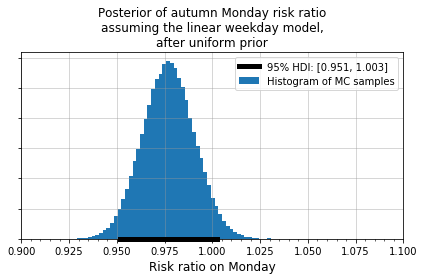

In [500]:
plt.xlim(0.9, 1.1)
plt.hist(fit['rr_day[1]'],
         bins=np.arange(*(param_space[[0,-1]] + 1), 1/512),
         density=True,
         label='Histogram of MC samples')
plots.plot_hdi_line(*hdi)
plt.legend()
plt.title('Posterior of autumn Monday risk ratio\n'
          'assuming the linear weekday model,\n'
          'after uniform prior')
plt.xlabel('Risk ratio on Monday')
plt.gca().set_yticklabels([])
plt.gcf().tight_layout()
plt.savefig('figs/posterior_mc_autumn.svg')
plt.show()

In [482]:
print("Mean:", np.mean(fit['rr_day[1]']))

Mean: 0.977033933825995


## Importance

Every year, about 790,000 Americans have a heart attack (in 2017). ([source](https://www.cdc.gov/heartdisease/heart_attack.htm))

Population in 2017: 326.5M

#### How close are the risk ratio and odds ratio? Some paper reported the latter.

In [166]:
N = 326_500_000
t = 790_000 / 365

y = 1.1 * t

RR = y / t
print("RR:", RR)

OR = (y / (N - y)) / (t / (N - t))
print("OR:", OR)

RR: 1.1
OR: 1.1000007292003917


In [169]:
normal_ami_risk = t / N
AR = y / N
print(f'absolute risk for Monday: {AR * 1e6 :.1f} per million '
      f'(instead of {normal_ami_risk * 1e6 :.1f} per million)')

absolute risk for Monday: 7.3 per million (instead of 6.6 per million)


1.6 billion people are affected by DST transitions globally.

Whole posttransitional spring week:

In [170]:
N = 1.6e9
normal_week_AMI = normal_ami_risk * N * 5

In [180]:
avg_rr = np.array([1.031, 1.05, 1.07])  # CrI_lb, mean, CrI_ub
inc_week_AMI = avg_rr * normal_week_AMI

In [182]:
normal_week_AMI, inc_week_AMI, inc_week_AMI - normal_week_AMI

(53032.36904487193,
 array([54676.37248526, 55683.98749712, 56744.63487801]),
 array([1644.00344039, 2651.61845224, 3712.26583314]))

Whole posttransitional autumn week:

In [268]:
mon_rr = np.array([0.951, 0.977, 1.003])  # lb, mean, ub
avg_rr = 1 + (mon_rr - 1) * 0.6
inc_week_AMI = avg_rr * normal_week_AMI

In [271]:
normal_week_AMI, inc_week_AMI, inc_week_AMI - normal_week_AMI

(53032.36904487193,
 array([51473.21739495, 52300.52235205, 53127.82730915]),
 array([-1559.15164992,  -731.84669282,    95.45826428]))

## Further research

Gather data on the age of AMI cases in posttransitional week and in control weeks, and model the former as a mixture of the age of the control group and a unimodal distribution. (Unimodal, because the age group that is most likely to be affected is the upper end of working age population, i.e. 50-65.)

Open source this model and those that follow.

## TODO

- would be nice to include the fall transition too, it comes basically for free and would give a complete picture of the pos/neg effects of DST.

## Conclusion

A standard argument against Bayesian methods is that the definition of the prior is subjective, which can have an influence on the results of the analysis. Meaningful and consistent probabilistic inference cannot be done without quantifying our initial beliefs and defining how different parameter values would result in different observations. However, in our case the observed data dominated the prior, and its prior  – all we have to assume is that .

# References


Cumming, G. (2014). The new statistics why and how. Psychological Science, 25(1), 7–29.

Andrew Gelman, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, and Donald B. Rubin. 2013. _Bayesian Data Analysis._ [link](http://www.stat.columbia.edu/~gelman/book/)

TODO others too.

## Further questions

**Q1.** What are the odds that there is a number of days that will have p-value less than 0.05?

The fact that every study has a separate time frame for their hypothesis, e.g. the 3/4/7/14/28 days following DST adjustment suggests that these hypotheses were made after the fact, not inspired by previous research.

Kirchberger2015:
> Overall, no significant changes of AMI risk during the first 3 days or 1 week after the transition to and from DST were found.

**Q2.** What are the odds that there will be a particular variable which makes it stick out like a sore thumb (just by random chance)? It's a function of the size of those strata: the smaller the stratum, the more likely there is an outlier. 

Kirchberger2015 (emphasis mine):
> However, subgroup analyses on the spring transition revealed significantly increased risks for men in the first 3 days after transition (RR 1.155, 95 % CI 1.000–1.334) and for persons who **took angiotensine converting enzyme (ACE) inhibitors** prior to the AMI (3 days: RR 1.489, 95 % CI 1.151–1.927; 1 week: RR 1.297, 95 % CI 1.063–1.582). After the clock shift in autumn, patients with a prior infarction had an increased risk to have a re-infarction (3 days: RR 1.319, 95 % CI 1.029–1.691; 1 week: RR 1.270, 95 % CI 1.048–1.539).

**Q3.** How are Bayes factors distributed under different values of $θ$ and N?

**Q4.** How to account for lower quality studies?

# Further figures

In [404]:
plt.rcParams['axes.labelsize'] = 'large'

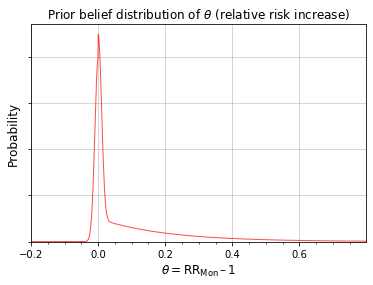

In [406]:
ax = plt.gca()
lb, ub = param_space[[0, -1]]

plt.plot(param_space, prior, c='red', lw=1, alpha=0.7, label='Prior')

ax.set_xlim(lb, ub)
ax.set_ylim(-0.01)

# ax.axvspan(xmin=ci_lb, xmax=ci_ub, lw=1, alpha=0.05,
#            label=f'{round(100*(1-alpha))}% central credible interval')

# ax.legend(loc='upper right', frameon=True)

ax.set_title(r"Prior belief distribution of $\theta$ (relative risk increase)")

ax.set_xlabel(r"$\theta = \mathrm{RR}_\mathrm{Mon} \, – \, 1$")
ax.set_ylabel("Probability")
ax.set_yticklabels([])

plt.grid(True, alpha=0.5)

plt.savefig('figs/prior_Monday.svg')

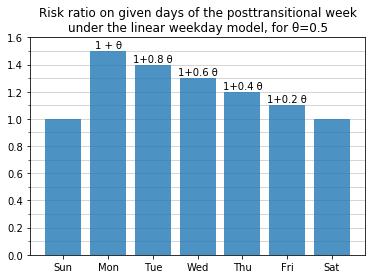

In [421]:
plt.title('Risk ratio on given days of the posttransitional week\n'
          'under the linear weekday model, for θ=0.5')
plt.bar(utils.DAYS_OF_WEEK, [1, 1.5, 1.4, 1.3, 1.2, 1.1, 1], zorder=10, alpha=0.8)
plt.minorticks_off()
plt.gca().set_yticks(np.arange(0.0, 1.7, 0.1), minor=True)
plt.grid(False, axis='x')
plt.grid(True, axis='y', which='both', alpha=0.5, zorder=0)
plt.text(1, 1.52, '1 + θ', horizontalalignment='center')
plt.text(2, 1.42, '1+0.8 θ', horizontalalignment='center')
plt.text(3, 1.32, '1+0.6 θ', horizontalalignment='center')
plt.text(4, 1.22, '1+0.4 θ', horizontalalignment='center')
plt.text(5, 1.12, '1+0.2 θ', horizontalalignment='center')
plt.savefig('figs/rr_example.svg')
plt.show()

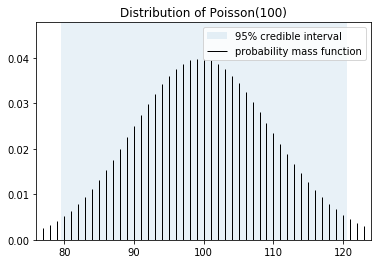

P(80 ≤ Poisson(100) ≤ 120) = 0.948


In [29]:
fig, ax = plt.subplots(1, 1, sharey=True)

fig.set_size_inches(6,4)

alpha = 0.05

# for mean, ax in zip([20,100], axs):
mean = 100
rv = st.poisson(mean)
lb, ub = rv.ppf(0.01), rv.ppf(0.99)
ax.set_xlim(lb-1, ub)
x = np.arange(lb, ub)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
          label=f'probability mass function')

ax.axvspan(xmin=rv.ppf(alpha/2)-1.5, xmax=rv.ppf(1-alpha/2)+0.5, lw=1, alpha=0.1,
          label=f'{round((1-alpha)*100)}% credible interval')
ax.legend(loc='upper right', frameon=True)

ax.set_title(f"Distribution of Poisson({mean})")

ax.set_ylim(bottom=0.0, top=1.2*st.poisson.pmf(100,100))

plt.savefig("../BayesianScience/figs/poisson-dist.svg")
plt.show()

print('P(80 ≤ Poisson(100) ≤ 120) = %.3f' %
          (st.poisson(100).cdf(120) - st.poisson(100).cdf(81)))